In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn import preprocessing
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Generate training data with varied noise

In [2]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return (x-5)**2 + epsilon
train_size = 300

X = np.geomspace(1, 10, train_size).reshape(-1, 1)
Y_true = f(X, sigma=0.0)
Y = np.zeros(X.shape)
for i in range(len(X)):
    x = X[i]
    if 4<x<10:
        Y[i] = f(x, sigma=abs(x)-4)
    else:
        Y[i] = f(x, sigma=0)        
print(X.shape)

(300, 1)


Visualize training data

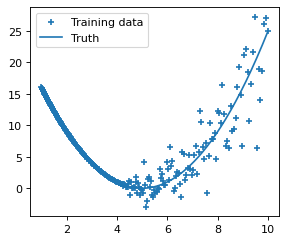

In [3]:
cm = 1/2.54
fig, ax = plt.subplots(1, figsize=(9*cm, 8*cm), sharey='row', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=.98, top=0.98, bottom=0.15, hspace = 0.65, wspace=0.15)
ax.scatter(X, Y, marker='+', label='Training data')
ax.plot(X, Y_true, label='Truth')
plt.legend()

Loss function, Distribution layer, and KL diverenge

In [4]:
def NLL(y, distr): 
  return -distr.log_prob(y) 

def normal_sp(params): 
  return tfp.distributions.Normal(loc=params[:,0:1], scale=1e-3
                                  + tf.math.softplus(0.05 * params[:,1:2])) #both parameters are learnable

kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X.shape[0] )
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X.shape[0] )

Build the network

In [5]:
inputs = tf.keras.layers.Input(shape=(X.shape[1],))

hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(32,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params)


model = Model(inputs=inputs, outputs=dist)
model.compile(Adam(learning_rate=0.0002), loss=NLL) 
model_params = Model(inputs=inputs, outputs=params)
model.summary()

C:\Users\fdenolas\Miniconda3\envs\bnn\lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\fdenolas\Miniconda3\envs\bnn\lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_flipout (DenseFlipout  (None, 20)               80        
 )                                                               
                                                                 
 dense_flipout_1 (DenseFlipo  (None, 32)               1344      
 ut)                                                             
                                                                 
 dense_flipout_2 (DenseFlipo  (None, 20)               1320      
 ut)                                                             
                                                                 
 dense_flipout_3 (DenseFlipo  (None, 2)                84        
 ut)                                                         

Train the network

In [6]:
epoch = 10000
batch_size = 150
model.fit(X, Y, epochs=epoch, verbose=1, batch_size = batch_size)

Epoch 1/10000
2/2 [==============================] - 2s 3ms/step - loss: 107.8294
Epoch 2/10000
2/2 [==============================] - 0s 3ms/step - loss: 108.2114
Epoch 3/10000
2/2 [==============================] - 0s 4ms/step - loss: 109.9775
Epoch 4/10000
2/2 [==============================] - 0s 3ms/step - loss: 108.2513
Epoch 5/10000
2/2 [==============================] - 0s 3ms/step - loss: 110.1118
Epoch 6/10000
2/2 [==============================] - 0s 3ms/step - loss: 109.9297
Epoch 7/10000
2/2 [==============================] - 0s 4ms/step - loss: 108.5554
Epoch 8/10000
2/2 [==============================] - 0s 5ms/step - loss: 110.0333
Epoch 9/10000
2/2 [==============================] - 0s 4ms/step - loss: 110.2402
Epoch 10/10000
2/2 [==============================] - 0s 4ms/step - loss: 108.4320
Epoch 11/10000
2/2 [==============================] - 0s 4ms/step - loss: 107.8445
Epoch 12/10000
2/2 [==============================] - 0s 5ms/step - loss: 109.1699
Epoch 13/1000

Epoch 100/10000
2/2 [==============================] - 0s 2ms/step - loss: 96.5718
Epoch 101/10000
2/2 [==============================] - 0s 3ms/step - loss: 93.9519
Epoch 102/10000
2/2 [==============================] - 0s 3ms/step - loss: 94.4029
Epoch 103/10000
2/2 [==============================] - 0s 4ms/step - loss: 95.3876
Epoch 104/10000
2/2 [==============================] - 0s 3ms/step - loss: 95.3078
Epoch 105/10000
2/2 [==============================] - 0s 4ms/step - loss: 94.2163
Epoch 106/10000
2/2 [==============================] - 0s 3ms/step - loss: 93.3968
Epoch 107/10000
2/2 [==============================] - 0s 3ms/step - loss: 91.9852
Epoch 108/10000
2/2 [==============================] - 0s 3ms/step - loss: 92.3626
Epoch 109/10000
2/2 [==============================] - 0s 3ms/step - loss: 91.4647
Epoch 110/10000
2/2 [==============================] - 0s 3ms/step - loss: 92.1543
Epoch 111/10000
2/2 [==============================] - 0s 3ms/step - loss: 92.0722
Epoc

2/2 [==============================] - 0s 3ms/step - loss: 47.0928
Epoch 199/10000
2/2 [==============================] - 0s 3ms/step - loss: 46.2882
Epoch 200/10000
2/2 [==============================] - 0s 3ms/step - loss: 46.5447
Epoch 201/10000
2/2 [==============================] - 0s 3ms/step - loss: 46.4703
Epoch 202/10000
2/2 [==============================] - 0s 3ms/step - loss: 46.6791
Epoch 203/10000
2/2 [==============================] - 0s 3ms/step - loss: 47.8968
Epoch 204/10000
2/2 [==============================] - 0s 3ms/step - loss: 44.6010
Epoch 205/10000
2/2 [==============================] - 0s 3ms/step - loss: 46.4846
Epoch 206/10000
2/2 [==============================] - 0s 4ms/step - loss: 45.1961
Epoch 207/10000
2/2 [==============================] - 0s 3ms/step - loss: 43.6465
Epoch 208/10000
2/2 [==============================] - 0s 4ms/step - loss: 45.1658
Epoch 209/10000
2/2 [==============================] - 0s 3ms/step - loss: 44.9812
Epoch 210/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 34.3025
Epoch 297/10000
2/2 [==============================] - 0s 3ms/step - loss: 35.5611
Epoch 298/10000
2/2 [==============================] - 0s 3ms/step - loss: 33.9610
Epoch 299/10000
2/2 [==============================] - 0s 3ms/step - loss: 35.1700
Epoch 300/10000
2/2 [==============================] - 0s 3ms/step - loss: 34.8097
Epoch 301/10000
2/2 [==============================] - 0s 3ms/step - loss: 33.8812
Epoch 302/10000
2/2 [==============================] - 0s 4ms/step - loss: 34.4456
Epoch 303/10000
2/2 [==============================] - 0s 3ms/step - loss: 34.0075
Epoch 304/10000
2/2 [==============================] - 0s 3ms/step - loss: 34.0279
Epoch 305/10000
2/2 [==============================] - 0s 2ms/step - loss: 33.8147
Epoch 306/10000
2/2 [==============================] - 0s 3ms/step - loss: 33.8125
Epoch 307/10000
2/2 [==============================] - 0s 3ms/step - loss: 33.6008
Epoch 308/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 25.2379
Epoch 395/10000
2/2 [==============================] - 0s 2ms/step - loss: 24.5849
Epoch 396/10000
2/2 [==============================] - 0s 3ms/step - loss: 24.9130
Epoch 397/10000
2/2 [==============================] - 0s 3ms/step - loss: 25.1515
Epoch 398/10000
2/2 [==============================] - 0s 2ms/step - loss: 24.8742
Epoch 399/10000
2/2 [==============================] - 0s 4ms/step - loss: 24.0000
Epoch 400/10000
2/2 [==============================] - 0s 3ms/step - loss: 24.4370
Epoch 401/10000
2/2 [==============================] - 0s 3ms/step - loss: 24.9213
Epoch 402/10000
2/2 [==============================] - 0s 3ms/step - loss: 24.0051
Epoch 403/10000
2/2 [==============================] - 0s 3ms/step - loss: 23.5819
Epoch 404/10000
2/2 [==============================] - 0s 4ms/step - loss: 24.4906
Epoch 405/10000
2/2 [==============================] - 0s 3ms/step - loss: 23.8424
Epoch 406/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 19.3754
Epoch 493/10000
2/2 [==============================] - 0s 3ms/step - loss: 19.7602
Epoch 494/10000
2/2 [==============================] - 0s 2ms/step - loss: 19.1056
Epoch 495/10000
2/2 [==============================] - 0s 3ms/step - loss: 19.4690
Epoch 496/10000
2/2 [==============================] - 0s 3ms/step - loss: 19.6878
Epoch 497/10000
2/2 [==============================] - 0s 3ms/step - loss: 19.0451
Epoch 498/10000
2/2 [==============================] - 0s 3ms/step - loss: 18.6168
Epoch 499/10000
2/2 [==============================] - 0s 2ms/step - loss: 19.0365
Epoch 500/10000
2/2 [==============================] - 0s 3ms/step - loss: 18.9557
Epoch 501/10000
2/2 [==============================] - 0s 3ms/step - loss: 19.1991
Epoch 502/10000
2/2 [==============================] - 0s 3ms/step - loss: 19.0271
Epoch 503/10000
2/2 [==============================] - 0s 3ms/step - loss: 18.7851
Epoch 504/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 17.0572
Epoch 591/10000
2/2 [==============================] - 0s 3ms/step - loss: 17.4407
Epoch 592/10000
2/2 [==============================] - 0s 3ms/step - loss: 17.1500
Epoch 593/10000
2/2 [==============================] - 0s 2ms/step - loss: 16.8930
Epoch 594/10000
2/2 [==============================] - 0s 3ms/step - loss: 16.8846
Epoch 595/10000
2/2 [==============================] - 0s 2ms/step - loss: 16.9505
Epoch 596/10000
2/2 [==============================] - 0s 3ms/step - loss: 16.6222
Epoch 597/10000
2/2 [==============================] - 0s 3ms/step - loss: 17.0237
Epoch 598/10000
2/2 [==============================] - 0s 2ms/step - loss: 16.7846
Epoch 599/10000
2/2 [==============================] - 0s 4ms/step - loss: 17.3279
Epoch 600/10000
2/2 [==============================] - 0s 3ms/step - loss: 17.1049
Epoch 601/10000
2/2 [==============================] - 0s 3ms/step - loss: 17.1170
Epoch 602/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 16.0892
Epoch 689/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.5513
Epoch 690/10000
2/2 [==============================] - 0s 3ms/step - loss: 16.0758
Epoch 691/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.8440
Epoch 692/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.8765
Epoch 693/10000
2/2 [==============================] - 0s 3ms/step - loss: 16.0703
Epoch 694/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.8477
Epoch 695/10000
2/2 [==============================] - 0s 2ms/step - loss: 15.6369
Epoch 696/10000
2/2 [==============================] - 0s 3ms/step - loss: 16.0857
Epoch 697/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.7902
Epoch 698/10000
2/2 [==============================] - 0s 2ms/step - loss: 15.7316
Epoch 699/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.6964
Epoch 700/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 15.3414
Epoch 787/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.1790
Epoch 788/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.1345
Epoch 789/10000
2/2 [==============================] - 0s 2ms/step - loss: 15.2505
Epoch 790/10000
2/2 [==============================] - 0s 2ms/step - loss: 15.2957
Epoch 791/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.1426
Epoch 792/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.1668
Epoch 793/10000
2/2 [==============================] - 0s 2ms/step - loss: 15.1571
Epoch 794/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.3741
Epoch 795/10000
2/2 [==============================] - 0s 4ms/step - loss: 15.2102
Epoch 796/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.4756
Epoch 797/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.3587
Epoch 798/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 14.9788
Epoch 885/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.8952
Epoch 886/10000
2/2 [==============================] - 0s 2ms/step - loss: 14.7266
Epoch 887/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.9208
Epoch 888/10000
2/2 [==============================] - 0s 5ms/step - loss: 14.8305
Epoch 889/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.8386
Epoch 890/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.9123
Epoch 891/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.8199
Epoch 892/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.9331
Epoch 893/10000
2/2 [==============================] - 0s 3ms/step - loss: 15.0348
Epoch 894/10000
2/2 [==============================] - 0s 4ms/step - loss: 15.0594
Epoch 895/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.9644
Epoch 896/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 14.5950
Epoch 983/10000
2/2 [==============================] - 0s 6ms/step - loss: 14.5903
Epoch 984/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.5792
Epoch 985/10000
2/2 [==============================] - 0s 5ms/step - loss: 14.6842
Epoch 986/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.4686
Epoch 987/10000
2/2 [==============================] - 0s 2ms/step - loss: 14.8134
Epoch 988/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.4771
Epoch 989/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.5207
Epoch 990/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.7774
Epoch 991/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.6204
Epoch 992/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.5435
Epoch 993/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.5822
Epoch 994/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 14.3452
Epoch 1080/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.2565
Epoch 1081/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.4120
Epoch 1082/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.4048
Epoch 1083/10000
2/2 [==============================] - 0s 2ms/step - loss: 14.2048
Epoch 1084/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.4326
Epoch 1085/10000
2/2 [==============================] - 0s 2ms/step - loss: 14.3751
Epoch 1086/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.3104
Epoch 1087/10000
2/2 [==============================] - 0s 2ms/step - loss: 14.3712
Epoch 1088/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.4283
Epoch 1089/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.4216
Epoch 1090/10000
2/2 [==============================] - 0s 2ms/step - loss: 14.2814
Epoch 109

2/2 [==============================] - 0s 3ms/step - loss: 14.3452
Epoch 1177/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.2118
Epoch 1178/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.1907
Epoch 1179/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.1722
Epoch 1180/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.2483
Epoch 1181/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.0660
Epoch 1182/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.2020
Epoch 1183/10000
2/2 [==============================] - 0s 4ms/step - loss: 14.2486
Epoch 1184/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.1872
Epoch 1185/10000
2/2 [==============================] - 0s 5ms/step - loss: 14.2631
Epoch 1186/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.1989
Epoch 1187/10000
2/2 [==============================] - 0s 5ms/step - loss: 14.1848
Epoch 118

2/2 [==============================] - 0s 3ms/step - loss: 14.0020
Epoch 1274/10000
2/2 [==============================] - 0s 4ms/step - loss: 13.8303
Epoch 1275/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.9790
Epoch 1276/10000
2/2 [==============================] - 0s 4ms/step - loss: 13.9615
Epoch 1277/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.0068
Epoch 1278/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.9969
Epoch 1279/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.9282
Epoch 1280/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.9276
Epoch 1281/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.9713
Epoch 1282/10000
2/2 [==============================] - 0s 3ms/step - loss: 14.0615
Epoch 1283/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.9064
Epoch 1284/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.8603
Epoch 128

2/2 [==============================] - 0s 5ms/step - loss: 13.8360
Epoch 1371/10000
2/2 [==============================] - 0s 2ms/step - loss: 13.8515
Epoch 1372/10000
2/2 [==============================] - 0s 5ms/step - loss: 13.7342
Epoch 1373/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.7824
Epoch 1374/10000
2/2 [==============================] - 0s 6ms/step - loss: 13.7458
Epoch 1375/10000
2/2 [==============================] - 0s 2ms/step - loss: 13.7055
Epoch 1376/10000
2/2 [==============================] - 0s 6ms/step - loss: 13.7531
Epoch 1377/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.7286
Epoch 1378/10000
2/2 [==============================] - 0s 5ms/step - loss: 13.7383
Epoch 1379/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.6267
Epoch 1380/10000
2/2 [==============================] - 0s 4ms/step - loss: 13.7078
Epoch 1381/10000
2/2 [==============================] - 0s 2ms/step - loss: 13.6824
Epoch 138

2/2 [==============================] - 0s 3ms/step - loss: 13.7067
Epoch 1468/10000
2/2 [==============================] - 0s 4ms/step - loss: 13.5445
Epoch 1469/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.7516
Epoch 1470/10000
2/2 [==============================] - 0s 4ms/step - loss: 13.5721
Epoch 1471/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.6215
Epoch 1472/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.6085
Epoch 1473/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.5995
Epoch 1474/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.6181
Epoch 1475/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.5174
Epoch 1476/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.5543
Epoch 1477/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.5965
Epoch 1478/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.5865
Epoch 147

2/2 [==============================] - 0s 3ms/step - loss: 13.3470
Epoch 1565/10000
2/2 [==============================] - 0s 5ms/step - loss: 13.4080
Epoch 1566/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.3819
Epoch 1567/10000
2/2 [==============================] - 0s 5ms/step - loss: 13.6093
Epoch 1568/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.4195
Epoch 1569/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.3165
Epoch 1570/10000
2/2 [==============================] - 0s 4ms/step - loss: 13.3904
Epoch 1571/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.4086
Epoch 1572/10000
2/2 [==============================] - 0s 6ms/step - loss: 13.4334
Epoch 1573/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.3962
Epoch 1574/10000
2/2 [==============================] - 0s 5ms/step - loss: 13.3766
Epoch 1575/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.3324
Epoch 157

2/2 [==============================] - 0s 2ms/step - loss: 13.4314
Epoch 1662/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.2708
Epoch 1663/10000
2/2 [==============================] - 0s 2ms/step - loss: 13.1449
Epoch 1664/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.1916
Epoch 1665/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.2071
Epoch 1666/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.2329
Epoch 1667/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.1598
Epoch 1668/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.2832
Epoch 1669/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.2052
Epoch 1670/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.2029
Epoch 1671/10000
2/2 [==============================] - 0s 3ms/step - loss: 13.3169
Epoch 1672/10000
2/2 [==============================] - 0s 2ms/step - loss: 13.2575
Epoch 167

2/2 [==============================] - 0s 2ms/step - loss: 13.0061
Epoch 1759/10000
2/2 [==============================] - 0s 5ms/step - loss: 12.9014
Epoch 1760/10000
2/2 [==============================] - 0s 2ms/step - loss: 13.1763
Epoch 1761/10000
2/2 [==============================] - 0s 4ms/step - loss: 12.9886
Epoch 1762/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.9378
Epoch 1763/10000
2/2 [==============================] - 0s 5ms/step - loss: 13.0236
Epoch 1764/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.9127
Epoch 1765/10000
2/2 [==============================] - 0s 5ms/step - loss: 12.9138
Epoch 1766/10000
2/2 [==============================] - 0s 2ms/step - loss: 13.0190
Epoch 1767/10000
2/2 [==============================] - 0s 6ms/step - loss: 12.9541
Epoch 1768/10000
2/2 [==============================] - 0s 2ms/step - loss: 12.9350
Epoch 1769/10000
2/2 [==============================] - 0s 6ms/step - loss: 13.0061
Epoch 177

2/2 [==============================] - 0s 3ms/step - loss: 12.7175
Epoch 1856/10000
2/2 [==============================] - 0s 2ms/step - loss: 12.7242
Epoch 1857/10000
2/2 [==============================] - 0s 4ms/step - loss: 12.7546
Epoch 1858/10000
2/2 [==============================] - 0s 2ms/step - loss: 12.6678
Epoch 1859/10000
2/2 [==============================] - 0s 5ms/step - loss: 12.6663
Epoch 1860/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.7444
Epoch 1861/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.6859
Epoch 1862/10000
2/2 [==============================] - 0s 2ms/step - loss: 12.8414
Epoch 1863/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.6539
Epoch 1864/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.6614
Epoch 1865/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.6804
Epoch 1866/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.6293
Epoch 186

2/2 [==============================] - 0s 3ms/step - loss: 12.4650
Epoch 1953/10000
2/2 [==============================] - 0s 2ms/step - loss: 12.3569
Epoch 1954/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.4135
Epoch 1955/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.4213
Epoch 1956/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.4398
Epoch 1957/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.4681
Epoch 1958/10000
2/2 [==============================] - 0s 2ms/step - loss: 12.5531
Epoch 1959/10000
2/2 [==============================] - 0s 4ms/step - loss: 12.4953
Epoch 1960/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.4871
Epoch 1961/10000
2/2 [==============================] - 0s 4ms/step - loss: 12.4202
Epoch 1962/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.5725
Epoch 1963/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.5349
Epoch 196

2/2 [==============================] - 0s 3ms/step - loss: 12.1538
Epoch 2050/10000
2/2 [==============================] - 0s 5ms/step - loss: 12.2506
Epoch 2051/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.3014
Epoch 2052/10000
2/2 [==============================] - 0s 5ms/step - loss: 12.3291
Epoch 2053/10000
2/2 [==============================] - 0s 2ms/step - loss: 12.0951
Epoch 2054/10000
2/2 [==============================] - 0s 6ms/step - loss: 12.1963
Epoch 2055/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.1496
Epoch 2056/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.1533
Epoch 2057/10000
2/2 [==============================] - 0s 2ms/step - loss: 12.1809
Epoch 2058/10000
2/2 [==============================] - 0s 4ms/step - loss: 12.2278
Epoch 2059/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.1915
Epoch 2060/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.2027
Epoch 206

2/2 [==============================] - 0s 3ms/step - loss: 12.0100
Epoch 2147/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.0994
Epoch 2148/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.0115
Epoch 2149/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.0475
Epoch 2150/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.0186
Epoch 2151/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.0992
Epoch 2152/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.0104
Epoch 2153/10000
2/2 [==============================] - 0s 3ms/step - loss: 12.0358
Epoch 2154/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.9809
Epoch 2155/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.9673
Epoch 2156/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.9873
Epoch 2157/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.9814
Epoch 215

2/2 [==============================] - 0s 4ms/step - loss: 11.8668
Epoch 2244/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.7766
Epoch 2245/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.8564
Epoch 2246/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.7881
Epoch 2247/10000
2/2 [==============================] - 0s 4ms/step - loss: 11.8301
Epoch 2248/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.7467
Epoch 2249/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.8152
Epoch 2250/10000
2/2 [==============================] - 0s 2ms/step - loss: 11.7409
Epoch 2251/10000
2/2 [==============================] - 0s 2ms/step - loss: 11.8224
Epoch 2252/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.7617
Epoch 2253/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.7429
Epoch 2254/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.8801
Epoch 225

2/2 [==============================] - 0s 4ms/step - loss: 11.6838
Epoch 2341/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.6148
Epoch 2342/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.6743
Epoch 2343/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.6258
Epoch 2344/10000
2/2 [==============================] - 0s 2ms/step - loss: 11.6414
Epoch 2345/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.6366
Epoch 2346/10000
2/2 [==============================] - 0s 2ms/step - loss: 11.6754
Epoch 2347/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.6258
Epoch 2348/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.6171
Epoch 2349/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.6381
Epoch 2350/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.7049
Epoch 2351/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.5691
Epoch 235

2/2 [==============================] - 0s 3ms/step - loss: 11.4682
Epoch 2438/10000
2/2 [==============================] - 0s 4ms/step - loss: 11.5223
Epoch 2439/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.5000
Epoch 2440/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.5484
Epoch 2441/10000
2/2 [==============================] - 0s 2ms/step - loss: 11.4677
Epoch 2442/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.6523
Epoch 2443/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.6413
Epoch 2444/10000
2/2 [==============================] - 0s 2ms/step - loss: 11.5357
Epoch 2445/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.4630
Epoch 2446/10000
2/2 [==============================] - 0s 2ms/step - loss: 11.5319
Epoch 2447/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.5841
Epoch 2448/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.4788
Epoch 244

2/2 [==============================] - 0s 3ms/step - loss: 11.2974
Epoch 2535/10000
2/2 [==============================] - 0s 4ms/step - loss: 11.3125
Epoch 2536/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.3039
Epoch 2537/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.2884
Epoch 2538/10000
2/2 [==============================] - 0s 2ms/step - loss: 11.2514
Epoch 2539/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.2658
Epoch 2540/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.2613
Epoch 2541/10000
2/2 [==============================] - 0s 6ms/step - loss: 11.2927
Epoch 2542/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.2809
Epoch 2543/10000
2/2 [==============================] - 0s 5ms/step - loss: 11.2746
Epoch 2544/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.2833
Epoch 2545/10000
2/2 [==============================] - 0s 4ms/step - loss: 11.3246
Epoch 254

2/2 [==============================] - 0s 3ms/step - loss: 11.1743
Epoch 2632/10000
2/2 [==============================] - 0s 2ms/step - loss: 11.0731
Epoch 2633/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.9879
Epoch 2634/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.9934
Epoch 2635/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.0300
Epoch 2636/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.1100
Epoch 2637/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.2507
Epoch 2638/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.0341
Epoch 2639/10000
2/2 [==============================] - 0s 2ms/step - loss: 11.1396
Epoch 2640/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.0061
Epoch 2641/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.1021
Epoch 2642/10000
2/2 [==============================] - 0s 3ms/step - loss: 11.0376
Epoch 264

2/2 [==============================] - 0s 3ms/step - loss: 11.0162
Epoch 2729/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.8469
Epoch 2730/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.9680
Epoch 2731/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.8592
Epoch 2732/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.9165
Epoch 2733/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.8680
Epoch 2734/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.9294
Epoch 2735/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.7825
Epoch 2736/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.8764
Epoch 2737/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.8664
Epoch 2738/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.9683
Epoch 2739/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.9335
Epoch 274

2/2 [==============================] - 0s 4ms/step - loss: 10.6863
Epoch 2826/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.7187
Epoch 2827/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.6660
Epoch 2828/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.6021
Epoch 2829/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.7088
Epoch 2830/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.7308
Epoch 2831/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.6919
Epoch 2832/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.7449
Epoch 2833/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.6470
Epoch 2834/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.7732
Epoch 2835/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.6750
Epoch 2836/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.6820
Epoch 283

2/2 [==============================] - 0s 3ms/step - loss: 10.4978
Epoch 2923/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.4959
Epoch 2924/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.4572
Epoch 2925/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.4121
Epoch 2926/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.5063
Epoch 2927/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.3985
Epoch 2928/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.5055
Epoch 2929/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.4912
Epoch 2930/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.5465
Epoch 2931/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.5350
Epoch 2932/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.4433
Epoch 2933/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.5290
Epoch 293

2/2 [==============================] - 0s 3ms/step - loss: 10.2470
Epoch 3020/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.3231
Epoch 3021/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.4216
Epoch 3022/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.3579
Epoch 3023/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.3394
Epoch 3024/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.2613
Epoch 3025/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.3400
Epoch 3026/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.3819
Epoch 3027/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.2185
Epoch 3028/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.4112
Epoch 3029/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.3011
Epoch 3030/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.3042
Epoch 303

2/2 [==============================] - 0s 3ms/step - loss: 10.1846
Epoch 3117/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.0887
Epoch 3118/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.1674
Epoch 3119/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.1018
Epoch 3120/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.1870
Epoch 3121/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.1130
Epoch 3122/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.1102
Epoch 3123/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.1890
Epoch 3124/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.1108
Epoch 3125/10000
2/2 [==============================] - 0s 2ms/step - loss: 10.1387
Epoch 3126/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.1926
Epoch 3127/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.1335
Epoch 312

2/2 [==============================] - 0s 3ms/step - loss: 9.9864
Epoch 3214/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9862
Epoch 3215/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.9851
Epoch 3216/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9815
Epoch 3217/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9072
Epoch 3218/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9673
Epoch 3219/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9916
Epoch 3220/10000
2/2 [==============================] - 0s 4ms/step - loss: 10.0296
Epoch 3221/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9549
Epoch 3222/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9143
Epoch 3223/10000
2/2 [==============================] - 0s 3ms/step - loss: 10.0440
Epoch 3224/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9296
Epoch 3225/10000
2/

2/2 [==============================] - 0s 3ms/step - loss: 9.7578
Epoch 3312/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7417
Epoch 3313/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7480
Epoch 3314/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.7813
Epoch 3315/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9037
Epoch 3316/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7748
Epoch 3317/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7937
Epoch 3318/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.8840
Epoch 3319/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.8376
Epoch 3320/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7461
Epoch 3321/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7723
Epoch 3322/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7520
Epoch 3323/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 9.5706
Epoch 3410/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6601
Epoch 3411/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5819
Epoch 3412/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.6096
Epoch 3413/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6795
Epoch 3414/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5517
Epoch 3415/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5891
Epoch 3416/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6479
Epoch 3417/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.6609
Epoch 3418/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.5198
Epoch 3419/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6340
Epoch 3420/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5814
Epoch 3421/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 9.4126
Epoch 3508/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.5182
Epoch 3509/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.3797
Epoch 3510/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5421
Epoch 3511/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.3314
Epoch 3512/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.3594
Epoch 3513/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.4249
Epoch 3514/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.4581
Epoch 3515/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.4657
Epoch 3516/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.3699
Epoch 3517/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.4988
Epoch 3518/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6028
Epoch 3519/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 9.2365
Epoch 3606/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2598
Epoch 3607/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.2126
Epoch 3608/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2489
Epoch 3609/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2279
Epoch 3610/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2326
Epoch 3611/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2167
Epoch 3612/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2803
Epoch 3613/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.3181
Epoch 3614/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.2562
Epoch 3615/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1838
Epoch 3616/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2364
Epoch 3617/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 9.0111
Epoch 3704/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0717
Epoch 3705/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1356
Epoch 3706/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1005
Epoch 3707/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0024
Epoch 3708/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.1705
Epoch 3709/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0944
Epoch 3710/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0986
Epoch 3711/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0331
Epoch 3712/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1238
Epoch 3713/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.0540
Epoch 3714/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9793
Epoch 3715/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 8.9163
Epoch 3802/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9655
Epoch 3803/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8120
Epoch 3804/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9115
Epoch 3805/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9142
Epoch 3806/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8109
Epoch 3807/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9370
Epoch 3808/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.9465
Epoch 3809/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.8439
Epoch 3810/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.7872
Epoch 3811/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9210
Epoch 3812/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9126
Epoch 3813/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 8.7067
Epoch 3900/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.8160
Epoch 3901/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7341
Epoch 3902/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.7439
Epoch 3903/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.8299
Epoch 3904/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7846
Epoch 3905/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7306
Epoch 3906/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8399
Epoch 3907/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7253
Epoch 3908/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.6939
Epoch 3909/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6728
Epoch 3910/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.7357
Epoch 3911/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 8.6086
Epoch 3998/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.5312
Epoch 3999/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6451
Epoch 4000/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6161
Epoch 4001/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.7185
Epoch 4002/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.5064
Epoch 4003/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.5198
Epoch 4004/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.5145
Epoch 4005/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4723
Epoch 4006/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.5359
Epoch 4007/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.8062
Epoch 4008/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.5645
Epoch 4009/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 8.4212
Epoch 4096/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.4697
Epoch 4097/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3860
Epoch 4098/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3807
Epoch 4099/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.4122
Epoch 4100/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.4249
Epoch 4101/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4331
Epoch 4102/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4426
Epoch 4103/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.4603
Epoch 4104/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3519
Epoch 4105/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4466
Epoch 4106/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4046
Epoch 4107/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 8.2725
Epoch 4194/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3147
Epoch 4195/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1750
Epoch 4196/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.2956
Epoch 4197/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.2299
Epoch 4198/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.2312
Epoch 4199/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1949
Epoch 4200/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3396
Epoch 4201/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2700
Epoch 4202/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.2052
Epoch 4203/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1884
Epoch 4204/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2017
Epoch 4205/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 8.0664
Epoch 4292/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.0915
Epoch 4293/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.2226
Epoch 4294/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.0755
Epoch 4295/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1087
Epoch 4296/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0823
Epoch 4297/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.1138
Epoch 4298/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0361
Epoch 4299/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1271
Epoch 4300/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.0669
Epoch 4301/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0996
Epoch 4302/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.1761
Epoch 4303/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 7.9971
Epoch 4390/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.9563
Epoch 4391/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9412
Epoch 4392/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.9153
Epoch 4393/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9595
Epoch 4394/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9648
Epoch 4395/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1782
Epoch 4396/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.0192
Epoch 4397/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9970
Epoch 4398/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1481
Epoch 4399/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0964
Epoch 4400/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.9319
Epoch 4401/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 7.8506
Epoch 4488/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7957
Epoch 4489/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.8452
Epoch 4490/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.8107
Epoch 4491/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8286
Epoch 4492/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.8559
Epoch 4493/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8394
Epoch 4494/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9064
Epoch 4495/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.8368
Epoch 4496/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8376
Epoch 4497/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7097
Epoch 4498/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8604
Epoch 4499/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 7.6464
Epoch 4586/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7263
Epoch 4587/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6733
Epoch 4588/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6225
Epoch 4589/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8913
Epoch 4590/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6724
Epoch 4591/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5719
Epoch 4592/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.5687
Epoch 4593/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6933
Epoch 4594/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6584
Epoch 4595/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.5898
Epoch 4596/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.6534
Epoch 4597/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 7.5783
Epoch 4684/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.4825
Epoch 4685/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.5552
Epoch 4686/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5603
Epoch 4687/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.5748
Epoch 4688/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4649
Epoch 4689/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5299
Epoch 4690/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4998
Epoch 4691/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.5802
Epoch 4692/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.5329
Epoch 4693/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5600
Epoch 4694/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4650
Epoch 4695/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 7.4714
Epoch 4782/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.3536
Epoch 4783/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3355
Epoch 4784/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4104
Epoch 4785/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4133
Epoch 4786/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4806
Epoch 4787/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.4318
Epoch 4788/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3910
Epoch 4789/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5189
Epoch 4790/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.4226
Epoch 4791/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3348
Epoch 4792/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3765
Epoch 4793/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 7.3997
Epoch 4880/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2012
Epoch 4881/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0984
Epoch 4882/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2282
Epoch 4883/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2761
Epoch 4884/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1964
Epoch 4885/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.2871
Epoch 4886/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2797
Epoch 4887/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2914
Epoch 4888/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.3152
Epoch 4889/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2025
Epoch 4890/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1994
Epoch 4891/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 7.0533
Epoch 4978/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.0189
Epoch 4979/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1141
Epoch 4980/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.0893
Epoch 4981/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0677
Epoch 4982/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1169
Epoch 4983/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0937
Epoch 4984/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0990
Epoch 4985/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.0974
Epoch 4986/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1165
Epoch 4987/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1923
Epoch 4988/10000
2/2 [==============================] - 0s 8ms/step - loss: 7.1643
Epoch 4989/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 6.9546
Epoch 5076/10000
2/2 [==============================] - 0s 7ms/step - loss: 7.0276
Epoch 5077/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.9505
Epoch 5078/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9564
Epoch 5079/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.1065
Epoch 5080/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.9392
Epoch 5081/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9861
Epoch 5082/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.0210
Epoch 5083/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0346
Epoch 5084/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.0304
Epoch 5085/10000
2/2 [==============================] - 0s 8ms/step - loss: 7.0297
Epoch 5086/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.9340
Epoch 5087/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 6.8550
Epoch 5174/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8296
Epoch 5175/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.0028
Epoch 5176/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.8040
Epoch 5177/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7956
Epoch 5178/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8826
Epoch 5179/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9219
Epoch 5180/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8416
Epoch 5181/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8865
Epoch 5182/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9972
Epoch 5183/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8343
Epoch 5184/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8795
Epoch 5185/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 6.6792
Epoch 5272/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6474
Epoch 5273/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7600
Epoch 5274/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.6685
Epoch 5275/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.7437
Epoch 5276/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6370
Epoch 5277/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6851
Epoch 5278/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8054
Epoch 5279/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.7701
Epoch 5280/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.7523
Epoch 5281/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6363
Epoch 5282/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7120
Epoch 5283/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 6.5884
Epoch 5370/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5645
Epoch 5371/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4652
Epoch 5372/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6301
Epoch 5373/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6317
Epoch 5374/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6761
Epoch 5375/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6016
Epoch 5376/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7964
Epoch 5377/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4681
Epoch 5378/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.6290
Epoch 5379/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6253
Epoch 5380/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5841
Epoch 5381/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 6.4603
Epoch 5468/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3897
Epoch 5469/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3361
Epoch 5470/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.4847
Epoch 5471/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.4782
Epoch 5472/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4574
Epoch 5473/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3928
Epoch 5474/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.4994
Epoch 5475/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4658
Epoch 5476/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5056
Epoch 5477/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4420
Epoch 5478/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3668
Epoch 5479/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 6.2453
Epoch 5566/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.3066
Epoch 5567/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3820
Epoch 5568/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2890
Epoch 5569/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3784
Epoch 5570/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2792
Epoch 5571/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3687
Epoch 5572/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4925
Epoch 5573/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3078
Epoch 5574/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4825
Epoch 5575/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2392
Epoch 5576/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3284
Epoch 5577/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 6.1974
Epoch 5664/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2181
Epoch 5665/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1538
Epoch 5666/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2272
Epoch 5667/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2196
Epoch 5668/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2432
Epoch 5669/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1987
Epoch 5670/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.1699
Epoch 5671/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.1919
Epoch 5672/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2512
Epoch 5673/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2068
Epoch 5674/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2551
Epoch 5675/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 6.0371
Epoch 5762/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.0686
Epoch 5763/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0610
Epoch 5764/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0658
Epoch 5765/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.1662
Epoch 5766/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.1053
Epoch 5767/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9857
Epoch 5768/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1280
Epoch 5769/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1121
Epoch 5770/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0231
Epoch 5771/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9907
Epoch 5772/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0912
Epoch 5773/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 5.9557
Epoch 5860/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8629
Epoch 5861/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9304
Epoch 5862/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9134
Epoch 5863/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9952
Epoch 5864/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0618
Epoch 5865/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.9614
Epoch 5866/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.0132
Epoch 5867/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9218
Epoch 5868/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9512
Epoch 5869/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9190
Epoch 5870/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.9577
Epoch 5871/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 5.9449
Epoch 5958/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8835
Epoch 5959/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8195
Epoch 5960/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9862
Epoch 5961/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.8287
Epoch 5962/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8261
Epoch 5963/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9826
Epoch 5964/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.8968
Epoch 5965/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8071
Epoch 5966/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7636
Epoch 5967/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7862
Epoch 5968/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8377
Epoch 5969/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 5.6960
Epoch 6056/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7690
Epoch 6057/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7431
Epoch 6058/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7366
Epoch 6059/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7365
Epoch 6060/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6716
Epoch 6061/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7164
Epoch 6062/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6750
Epoch 6063/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.8881
Epoch 6064/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7359
Epoch 6065/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7551
Epoch 6066/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.8140
Epoch 6067/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 5.5733
Epoch 6154/10000
2/2 [==============================] - 0s 9ms/step - loss: 5.5994
Epoch 6155/10000
2/2 [==============================] - 0s 10ms/step - loss: 5.6427
Epoch 6156/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.7115
Epoch 6157/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.6642
Epoch 6158/10000
2/2 [==============================] - 0s 8ms/step - loss: 5.5762
Epoch 6159/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.5450
Epoch 6160/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8045
Epoch 6161/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.6051
Epoch 6162/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.6061
Epoch 6163/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.5787
Epoch 6164/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6763
Epoch 6165/10000
2/2

2/2 [==============================] - 0s 4ms/step - loss: 5.6271
Epoch 6252/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.4603
Epoch 6253/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.5772
Epoch 6254/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.4835
Epoch 6255/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6043
Epoch 6256/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.5079
Epoch 6257/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5136
Epoch 6258/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.5167
Epoch 6259/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.6085
Epoch 6260/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.6951
Epoch 6261/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4861
Epoch 6262/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4313
Epoch 6263/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 5.4650
Epoch 6350/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.4226
Epoch 6351/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3756
Epoch 6352/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.4432
Epoch 6353/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4068
Epoch 6354/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3795
Epoch 6355/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.4157
Epoch 6356/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3731
Epoch 6357/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3766
Epoch 6358/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.4258
Epoch 6359/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.4775
Epoch 6360/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4564
Epoch 6361/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 5.2738
Epoch 6448/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.4446
Epoch 6449/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2656
Epoch 6450/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3134
Epoch 6451/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3598
Epoch 6452/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2752
Epoch 6453/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3668
Epoch 6454/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.3263
Epoch 6455/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3525
Epoch 6456/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3779
Epoch 6457/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3124
Epoch 6458/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.2430
Epoch 6459/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 5.2131
Epoch 6546/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4567
Epoch 6547/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2339
Epoch 6548/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.2196
Epoch 6549/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.2437
Epoch 6550/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1577
Epoch 6551/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.2114
Epoch 6552/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1372
Epoch 6553/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1416
Epoch 6554/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.2549
Epoch 6555/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2995
Epoch 6556/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2773
Epoch 6557/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 5.1719
Epoch 6644/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1336
Epoch 6645/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1941
Epoch 6646/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0874
Epoch 6647/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1128
Epoch 6648/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1452
Epoch 6649/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.4047
Epoch 6650/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.1412
Epoch 6651/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0850
Epoch 6652/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0745
Epoch 6653/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.0931
Epoch 6654/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2356
Epoch 6655/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 5.0642
Epoch 6742/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0211
Epoch 6743/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1055
Epoch 6744/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0217
Epoch 6745/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9831
Epoch 6746/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0012
Epoch 6747/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9567
Epoch 6748/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0499
Epoch 6749/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0496
Epoch 6750/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8995
Epoch 6751/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9777
Epoch 6752/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9478
Epoch 6753/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 4.9813
Epoch 6840/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0200
Epoch 6841/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9357
Epoch 6842/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.9147
Epoch 6843/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1013
Epoch 6844/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9317
Epoch 6845/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1046
Epoch 6846/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9591
Epoch 6847/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.8803
Epoch 6848/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0332
Epoch 6849/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8884
Epoch 6850/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.9519
Epoch 6851/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 4.8595
Epoch 6938/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.9933
Epoch 6939/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7773
Epoch 6940/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8457
Epoch 6941/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7631
Epoch 6942/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8809
Epoch 6943/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.7899
Epoch 6944/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8099
Epoch 6945/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8387
Epoch 6946/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8201
Epoch 6947/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7858
Epoch 6948/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8171
Epoch 6949/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 4.7922
Epoch 7036/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.7549
Epoch 7037/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7785
Epoch 7038/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7521
Epoch 7039/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7276
Epoch 7040/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7182
Epoch 7041/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7050
Epoch 7042/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7036
Epoch 7043/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7278
Epoch 7044/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6828
Epoch 7045/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6735
Epoch 7046/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7493
Epoch 7047/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 4.5590
Epoch 7134/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6355
Epoch 7135/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6879
Epoch 7136/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.6005
Epoch 7137/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7142
Epoch 7138/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7688
Epoch 7139/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.6885
Epoch 7140/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6098
Epoch 7141/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6735
Epoch 7142/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7437
Epoch 7143/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.6501
Epoch 7144/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5392
Epoch 7145/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 4.5837
Epoch 7232/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.5619
Epoch 7233/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5996
Epoch 7234/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.5885
Epoch 7235/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6122
Epoch 7236/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4724
Epoch 7237/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5382
Epoch 7238/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6786
Epoch 7239/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5474
Epoch 7240/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6116
Epoch 7241/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5475
Epoch 7242/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6756
Epoch 7243/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 4.4222
Epoch 7330/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5373
Epoch 7331/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.6433
Epoch 7332/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3837
Epoch 7333/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4832
Epoch 7334/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5790
Epoch 7335/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4477
Epoch 7336/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.4332
Epoch 7337/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5069
Epoch 7338/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4326
Epoch 7339/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.4352
Epoch 7340/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4762
Epoch 7341/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 4.4427
Epoch 7428/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4658
Epoch 7429/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3745
Epoch 7430/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4730
Epoch 7431/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.4056
Epoch 7432/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3510
Epoch 7433/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.3671
Epoch 7434/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3576
Epoch 7435/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.3759
Epoch 7436/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4926
Epoch 7437/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3628
Epoch 7438/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.3624
Epoch 7439/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 4.3510
Epoch 7526/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4510
Epoch 7527/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5221
Epoch 7528/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3547
Epoch 7529/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.3175
Epoch 7530/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.3207
Epoch 7531/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3951
Epoch 7532/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3623
Epoch 7533/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2995
Epoch 7534/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.3628
Epoch 7535/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3192
Epoch 7536/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2759
Epoch 7537/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 4.2799
Epoch 7624/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.1506
Epoch 7625/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2502
Epoch 7626/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3876
Epoch 7627/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4006
Epoch 7628/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.2763
Epoch 7629/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.2200
Epoch 7630/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2806
Epoch 7631/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.3536
Epoch 7632/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2736
Epoch 7633/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2681
Epoch 7634/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.2930
Epoch 7635/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 4.2130
Epoch 7722/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.4024
Epoch 7723/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.1973
Epoch 7724/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2185
Epoch 7725/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2388
Epoch 7726/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1694
Epoch 7727/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1841
Epoch 7728/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1597
Epoch 7729/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1987
Epoch 7730/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2399
Epoch 7731/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.2025
Epoch 7732/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1868
Epoch 7733/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 4.1310
Epoch 7820/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1909
Epoch 7821/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0481
Epoch 7822/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.0727
Epoch 7823/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0739
Epoch 7824/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1229
Epoch 7825/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0883
Epoch 7826/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1091
Epoch 7827/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0431
Epoch 7828/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1163
Epoch 7829/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1516
Epoch 7830/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2755
Epoch 7831/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.9852
Epoch 7918/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0506
Epoch 7919/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1388
Epoch 7920/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.0874
Epoch 7921/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.1512
Epoch 7922/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9732
Epoch 7923/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0795
Epoch 7924/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1014
Epoch 7925/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0860
Epoch 7926/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0328
Epoch 7927/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0375
Epoch 7928/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1343
Epoch 7929/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 4.0061
Epoch 8016/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9740
Epoch 8017/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9729
Epoch 8018/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9440
Epoch 8019/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0193
Epoch 8020/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9808
Epoch 8021/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.9997
Epoch 8022/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0010
Epoch 8023/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.0800
Epoch 8024/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.0933
Epoch 8025/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0056
Epoch 8026/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9716
Epoch 8027/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 3.9430
Epoch 8114/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9710
Epoch 8115/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8928
Epoch 8116/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9718
Epoch 8117/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.0358
Epoch 8118/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0470
Epoch 8119/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.1580
Epoch 8120/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9144
Epoch 8121/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9960
Epoch 8122/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8832
Epoch 8123/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9047
Epoch 8124/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9301
Epoch 8125/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.9082
Epoch 8212/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9498
Epoch 8213/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9888
Epoch 8214/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.8710
Epoch 8215/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8147
Epoch 8216/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8797
Epoch 8217/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9136
Epoch 8218/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8798
Epoch 8219/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8749
Epoch 8220/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9302
Epoch 8221/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8549
Epoch 8222/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.8735
Epoch 8223/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.9422
Epoch 8310/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8456
Epoch 8311/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9105
Epoch 8312/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7451
Epoch 8313/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8252
Epoch 8314/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7569
Epoch 8315/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7562
Epoch 8316/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7565
Epoch 8317/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8315
Epoch 8318/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8514
Epoch 8319/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8981
Epoch 8320/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7997
Epoch 8321/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 3.7851
Epoch 8408/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.7694
Epoch 8409/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7676
Epoch 8410/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8416
Epoch 8411/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8493
Epoch 8412/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8624
Epoch 8413/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8207
Epoch 8414/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7979
Epoch 8415/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7806
Epoch 8416/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7786
Epoch 8417/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7449
Epoch 8418/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.7824
Epoch 8419/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.6570
Epoch 8506/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8230
Epoch 8507/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7635
Epoch 8508/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9393
Epoch 8509/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6429
Epoch 8510/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.9007
Epoch 8511/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7826
Epoch 8512/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.6639
Epoch 8513/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7336
Epoch 8514/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7008
Epoch 8515/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7391
Epoch 8516/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6816
Epoch 8517/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 3.6575
Epoch 8604/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5995
Epoch 8605/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.6841
Epoch 8606/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6516
Epoch 8607/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.6810
Epoch 8608/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.7003
Epoch 8609/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.7075
Epoch 8610/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7908
Epoch 8611/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.6696
Epoch 8612/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.7134
Epoch 8613/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.6971
Epoch 8614/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.7185
Epoch 8615/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.6218
Epoch 8702/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6943
Epoch 8703/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6029
Epoch 8704/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5937
Epoch 8705/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.6995
Epoch 8706/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6081
Epoch 8707/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.6044
Epoch 8708/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5917
Epoch 8709/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5700
Epoch 8710/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.7802
Epoch 8711/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6531
Epoch 8712/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8130
Epoch 8713/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.6364
Epoch 8800/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7662
Epoch 8801/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5685
Epoch 8802/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6074
Epoch 8803/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6413
Epoch 8804/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6709
Epoch 8805/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6444
Epoch 8806/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5459
Epoch 8807/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5873
Epoch 8808/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7103
Epoch 8809/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6809
Epoch 8810/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5596
Epoch 8811/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.4510
Epoch 8898/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5352
Epoch 8899/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.6269
Epoch 8900/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5843
Epoch 8901/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5170
Epoch 8902/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5317
Epoch 8903/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5430
Epoch 8904/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.5565
Epoch 8905/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6479
Epoch 8906/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5184
Epoch 8907/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4969
Epoch 8908/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6053
Epoch 8909/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.5028
Epoch 8996/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8442
Epoch 8997/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4664
Epoch 8998/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5067
Epoch 8999/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.5078
Epoch 9000/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7165
Epoch 9001/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4983
Epoch 9002/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4555
Epoch 9003/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4572
Epoch 9004/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5668
Epoch 9005/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5844
Epoch 9006/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5690
Epoch 9007/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.8481
Epoch 9094/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4163
Epoch 9095/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5227
Epoch 9096/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4893
Epoch 9097/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4949
Epoch 9098/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.6176
Epoch 9099/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5165
Epoch 9100/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6514
Epoch 9101/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4883
Epoch 9102/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6128
Epoch 9103/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5561
Epoch 9104/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4048
Epoch 9105/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.5053
Epoch 9192/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5100
Epoch 9193/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3994
Epoch 9194/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5675
Epoch 9195/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.5210
Epoch 9196/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.4241
Epoch 9197/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.4659
Epoch 9198/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3812
Epoch 9199/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4092
Epoch 9200/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4548
Epoch 9201/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.4690
Epoch 9202/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4171
Epoch 9203/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 3.4474
Epoch 9290/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3675
Epoch 9291/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3674
Epoch 9292/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3596
Epoch 9293/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5753
Epoch 9294/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4731
Epoch 9295/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5168
Epoch 9296/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5828
Epoch 9297/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3813
Epoch 9298/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5196
Epoch 9299/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4310
Epoch 9300/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3459
Epoch 9301/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 3.3991
Epoch 9388/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3115
Epoch 9389/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4058
Epoch 9390/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4413
Epoch 9391/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3488
Epoch 9392/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4031
Epoch 9393/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3870
Epoch 9394/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3479
Epoch 9395/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4257
Epoch 9396/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.5676
Epoch 9397/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4776
Epoch 9398/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.3226
Epoch 9399/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.3697
Epoch 9486/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3158
Epoch 9487/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3912
Epoch 9488/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4230
Epoch 9489/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.3601
Epoch 9490/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3180
Epoch 9491/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3596
Epoch 9492/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3116
Epoch 9493/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.3360
Epoch 9494/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3424
Epoch 9495/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3092
Epoch 9496/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3268
Epoch 9497/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.3436
Epoch 9584/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3578
Epoch 9585/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3572
Epoch 9586/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3547
Epoch 9587/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2564
Epoch 9588/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2499
Epoch 9589/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3330
Epoch 9590/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3467
Epoch 9591/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3388
Epoch 9592/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3905
Epoch 9593/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3297
Epoch 9594/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2966
Epoch 9595/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.2701
Epoch 9682/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.2579
Epoch 9683/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2646
Epoch 9684/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2681
Epoch 9685/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4038
Epoch 9686/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3075
Epoch 9687/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3036
Epoch 9688/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3176
Epoch 9689/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3462
Epoch 9690/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3277
Epoch 9691/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3251
Epoch 9692/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3339
Epoch 9693/10000
2/2 

2/2 [==============================] - 0s 2ms/step - loss: 3.2975
Epoch 9780/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3317
Epoch 9781/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3467
Epoch 9782/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2817
Epoch 9783/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2746
Epoch 9784/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4368
Epoch 9785/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2676
Epoch 9786/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2429
Epoch 9787/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3264
Epoch 9788/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2362
Epoch 9789/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2737
Epoch 9790/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3003
Epoch 9791/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.2526
Epoch 9878/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.2806
Epoch 9879/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3420
Epoch 9880/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2440
Epoch 9881/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3396
Epoch 9882/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2416
Epoch 9883/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3162
Epoch 9884/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3710
Epoch 9885/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2723
Epoch 9886/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3548
Epoch 9887/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2827
Epoch 9888/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1768
Epoch 9889/10000
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 3.3204
Epoch 9976/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1970
Epoch 9977/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.2707
Epoch 9978/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2285
Epoch 9979/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2147
Epoch 9980/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2328
Epoch 9981/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2510
Epoch 9982/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2465
Epoch 9983/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.2479
Epoch 9984/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2500
Epoch 9985/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2841
Epoch 9986/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.3366
Epoch 9987/10000
2/2 

Test the network

2/2 [==============================] - 0s 2ms/step


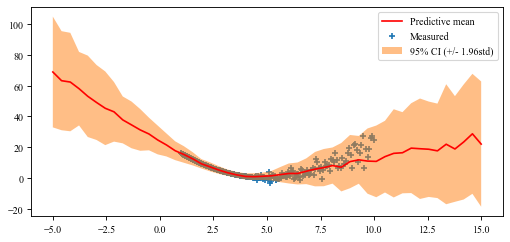

In [7]:
cm = 1/2.54  # centimeters in inches
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 9

X_test = np.linspace(-5, 15, 50).reshape(-1, 1)
Y_test = np.zeros([len(X_test), 100])
for j in range(100):
    Y_test[:,j]= np.squeeze(model.predict(X_test))
Pred = np.mean(Y_test, axis=1)
Stdv = np.std(Y_test, axis=1)

X_test = np.squeeze(X_test)    
fig, ax = plt.subplots(1, figsize=(17*cm, 8*cm), sharey='row', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=.98, top=0.98, bottom=0.15, hspace = 0.65, wspace=0.15)
ax.plot(X_test, Pred, 'r-', label='Predictive mean');
ax.scatter(X,Y, marker='+', label='Measured');
ax.fill_between(X_test,Pred+1.96*Stdv,Pred-1.96*Stdv,
                 alpha=0.5, label='95% CI (+/- 1.96std)')
ax.legend()

Compute the model uncertainty

In [8]:
def compute_predictions_pbnn(model, examples):
    prediction_distribution= model(examples)
    prediction_mean = np.squeeze(prediction_distribution.mean().numpy())
    prediction_stdv = np.squeeze(prediction_distribution.stddev().numpy())
    # The 95% CI is computed as mean ± (1.96 * stdv)
    upper = (prediction_mean + (1.96 * prediction_stdv))
    lower = (prediction_mean - (1.96 * prediction_stdv))

    return prediction_mean, prediction_stdv, upper, lower


Means = np.zeros([len(X_test), 100])
Stdvs = np.zeros([len(X_test), 100])
for j in range(100):
    prediction_mean, prediction_stdv, upper, lower = compute_predictions_pbnn(model, X_test)
    Means[:,j] = prediction_mean
    Stdvs[:,j] = prediction_stdv

Expected_Mean = np.mean(Means,axis=1)
Standdev_Mean = np.std(Means,axis=1)

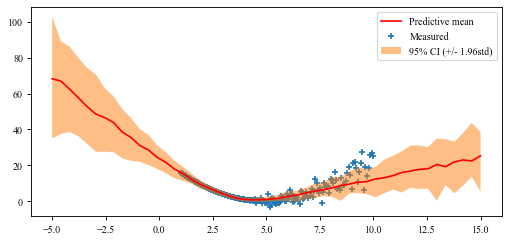

In [9]:
fig, ax = plt.subplots(1, figsize=(17*cm, 8*cm), sharey='row', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=.98, top=0.98, bottom=0.15, hspace = 0.65, wspace=0.15)
ax.plot(X_test, Expected_Mean, 'r-', label='Predictive mean');
ax.scatter(X,Y, marker='+', label='Measured');
ax.fill_between(X_test,Pred+1.96*Standdev_Mean,Pred-1.96*Standdev_Mean,
                 alpha=0.5, label='95% CI (+/- 1.96std)')
ax.legend()